<a href="https://colab.research.google.com/github/prinzessinmarlenifee/SenseCap/blob/main/SenseCap_v4-2_dataaugment_global_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Global Model with Data Augmentation

##short overview



Saving model and checkpoints for Zwischenspeicherung

CSV-sensor data sheet
1.   wrist
2.   seat
3.  head
-> 3 Sensoren, 9 Spalten
-> checkt erste und zweite Zeile für header (da unterschiedlich)

*   hot encoding for labeling
 Action, Pedaling, Resting, Pushing

 Summary at end with


*   test accuracy
*   confusion matrix

-> saved and stored in Drive as csv and png file





all data is stored in Drive

##Model Choice


✅ Teil 2: Ist CNN + LSTM eine gute Architektur für IMU-Zeitreihendaten?

Ja, das ist eine bewährte Kombination – besonders bei IMU-Daten (z. B. Accelerometer/Gyroscope), weil:
🔎 Warum CNN?

    Erkennt lokale Muster in kurzen Zeitfenstern (z. B. Bewegungsphasen)

    Spart Rechenzeit, da es weniger Parameter hat als ein reines LSTM

🔁 Warum LSTM?

    Erkennt zeitliche Abhängigkeiten (z. B. Bewegungsabfolgen)

    Ideal für sequentielle Daten, wie du sie hast

✅ Alternativen oder Erweiterungen

Falls du später mehr Leistung brauchst:

    Bidirectional LSTM → besser für symmetrische Bewegungsabfolgen

    Residual CNN Blocks → für tiefere Netzwerke

    Transformer → wenn du sehr viele Daten und lange Sequenzen hast

##Setup und Vorbereitung

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Trouble-shooting google drive

In [ ]:
#lölscht colab cache
!rm -rf /content/drive


rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.file-revisions-by-id': Operation canceled
rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
if os.path.ismount('/content/drive'):
    print("Drive ist schon gemountet – wird entmountet.")


drive.mount('/content/drive')


Drive ist schon gemountet – wird entmountet.
Mounted at /content/drive


###Packeages and setup

In [7]:
#import packages
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models


In [8]:
# --- PARAMETER ---
sampling_rate = 60       # 60 Hz nach SDI-Algorithmus
window_size = 60         # 1 Sekunde = 60 Frames
step_size = 30           # 50% Überlappung

# Basisverzeichnis (sollte die 18 Session-Ordner enthalten)
base_dir = '/content/drive/MyDrive/ML-MTB-Modell/IMU-Sessions/'


#Sessions einlesen

In [9]:
#prints founded sessions below
session_dirs = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])
print(f"Gefundene Sessions: {len(session_dirs)} -> {session_dirs}")


Gefundene Sessions: 12 -> ['Session_01', 'Session_02', 'Session_03', 'Session_05', 'Session_06', 'Session_07', 'Session_09', 'Session_10', 'Session_11', 'Session_12', 'Session_13', 'Session_14']


Fuktionen zum LAbel-Parsing und Datei finden

In [10]:
# 5.1 parse_hot_labels: Liest die _hot.json-Datei ein, erstellt für jeden Frame ein Label
def parse_hot_labels(json_path, total_frames):
    with open(json_path, 'r') as f:
        data = json.load(f)
    entries = data['button_presses'].strip().split(';')

    label_changes = []
    for entry in entries:
        if ':' in entry:
            label, frame = entry.strip().split(':')
            label = label.strip()
            # Korrigiere evtl. "Peadling" → "Pedaling"
            if label.lower() == 'peadling':
                label = 'Pedaling'
            label_changes.append((int(frame.strip()), label))

    frame_labels = ['Unknown'] * total_frames
    for i, (start_frame, label) in enumerate(label_changes):
        end_frame = label_changes[i + 1][0] if i + 1 < len(label_changes) else total_frames
        for f in range(start_frame, min(end_frame, total_frames)):
            frame_labels[f] = label
    return frame_labels

# 5.2 find_sensor_file: Findet CSV-Datei, deren Name mit dem Prefix beginnt (Head_, Wrist_, Seat_)
def find_sensor_file(folder, prefix):
    for f in os.listdir(folder):
        if f.lower().startswith(prefix.lower()):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Prefix '{prefix}' in {folder} gefunden.")

# 5.3 find_hot_file: Findet JSON-Datei, deren Name auf "_hot.json" endet
def find_hot_file(folder):
    for f in os.listdir(folder):
        if f.lower().endswith('_hot.json'):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Suffix '_hot.json' in {folder} gefunden.")


# 6. Fensterung für drei Sensoren kombinieren

In [ ]:
def window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels):
    X_windows, y_windows = [], []
    total_frames = len(frame_labels)

    # Annahme: head_data, wrist_data, seat_data haben alle dieselbe Anzahl Zeilen = total_frames
    for start in range(0, total_frames - window_size + 1, step_size):
        end = start + window_size

        win_h = head_data[start:end]    # (window_size, 6)
        win_w = wrist_data[start:end]
        win_s = seat_data[start:end]
        window = np.concatenate([win_h, win_w, win_s], axis=1)  # → (window_size, 18)

        label_window = frame_labels[start:end]
        dominant_label = Counter(label_window).most_common(1)[0][0]
        if dominant_label == 'Unknown':
            continue

        X_windows.append(window)
        y_windows.append(dominant_label)

    return np.array(X_windows), np.array(y_windows)


#7. Daten einlesen und Fenster / Labels erzeugen
→ Nach Ausführung siehst du für jede Session etwa: “→ 153 Fenster, 3 Klassen” etc.

In [ ]:
#Vorbereitung
sessions_X = []
sessions_y = []
valid_sessions = []  # <- neue Liste! mit nur valid sessions
skipped_sessions = []

#features definieren:
features = ['Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

#Funktionen für Daten einlesen
def smart_feature_filter(df):
    # alles lowercase und leerzeichenfrei vergleichen
    keep = [col for col in df.columns if any(kw in col.lower() for kw in ['euler', 'acc', 'gyr'])]
    return df[keep]

def print_csv_headers(path, label):
    with open(path, 'r') as f:
        lines = f.readlines()
    print(f"\n📋 {label} → Datei: {os.path.basename(path)}")
    print("   Zeile 0:", lines[0].strip())
    print("   Zeile 1:", lines[1].strip())


def inspect_sensor_csv(path):
    df = pd.read_csv(path, sep=',', skiprows=1)
    df.columns = df.columns.str.strip()
    print(f"📊 {os.path.basename(path)}: {df.shape[1]} Spalten")
    print("   → Spaltennamen:", df.columns.tolist())




def load_sensor_csv(path):
  import csv

  # Erste zwei Zeilen lesen
  with open(path, 'r') as f:
      reader = csv.reader(f)
      first_line = next(reader)
      second_line = next(reader)

  # Prüfen ob erste Zeile ein Header ist (z. B. mit bekannten Schlüsselwörtern)
  first_line_str = ",".join(first_line).lower()
  if any(kw in first_line_str for kw in ['euler', 'acc', 'gyr']):
      skip = 0
  else:
      skip = 1

  # Einlesen
  df = pd.read_csv(path, sep=',', skiprows=skip)
  df.columns = df.columns.str.strip()

  # Features filtern
  df = smart_feature_filter(df)

  # Numerisch umwandeln und NaN behandeln
  df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

  return df.values

  print(f"🔍 {os.path.basename(path)}: Header {'erste Zeile' if skip==0 else 'zweite Zeile'}")




# --- Hauptschleife ---
for sess_dir in session_dirs:
    print(f"\n📂 Lade Session: {sess_dir}")
    session_path = os.path.join(base_dir, sess_dir)


    # 7.1 Sensor-Dateien finden
    head_path  = find_sensor_file(session_path, 'Head_')
    wrist_path = find_sensor_file(session_path, 'Wrist_')
    seat_path  = find_sensor_file(session_path, 'Seat_')

    # 7.2 Hot-JSON-Datei finden
    hot_path = find_hot_file(session_path)

    inspect_sensor_csv(head_path)
    inspect_sensor_csv(wrist_path)
    inspect_sensor_csv(seat_path)


    #print csv-heads for debugging & checking (oben definierte function print_csv_headers)
    #print_csv_headers(head_path, 'Head')
    #print_csv_headers(wrist_path, 'Wrist')
    #print_csv_headers(seat_path, 'Seat')




    # 7.3 IMU-Daten laden
    #funktion um imu laden
    #aktuelles Problem: header in der zweiten Zeile, seperator ',' , erkennt nur zwei spalten beim einlesen



    head_data  = load_sensor_csv(head_path)
    wrist_data = load_sensor_csv(wrist_path)
    seat_data  = load_sensor_csv(seat_path)




    print(f"📊 Sensorlängen: Head={head_data.shape}, Wrist={wrist_data.shape}, Seat={seat_data.shape}")

    #expected_features = 27  # 3 Sensoren × 9 Features (oben definiert)
   # if X_win.shape[1:] != (window_size, expected_features):
    #      print(f"⚠️ Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
     #     skipped_sessions.append(sess_dir)
      #    continue



    #7.4 Labels laden
    total_frames = min(head_data.shape[0], wrist_data.shape[0], seat_data.shape[0])
    frame_labels = parse_hot_labels(hot_path, total_frames)



    # 7.5 Sicherheitskürzung (später optional mit synch.json ersetzen)
    head_data  = head_data[:total_frames]
    wrist_data = wrist_data[:total_frames]
    seat_data  = seat_data[:total_frames]
    frame_labels = frame_labels[:total_frames]


    # 7.6 Fensterung & Label-Zuweisung
    X_win, y_win = window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels)

    # 5. Gültigkeit prüfen
    if len(X_win) == 0:
        print(f"⚠️  Session {sess_dir} übersprungen – keine gültigen Fenster.")
        skipped_sessions.append(sess_dir)
        continue

    expected_features = 27  # oder dynamisch aus den Daten

    if X_win.shape[1:] != (window_size, expected_features):
        print(f"⚠️  Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
        skipped_sessions.append(sess_dir)
        continue


        # 6. Speichern
    sessions_X.append(X_win)
    sessions_y.append(y_win)
    valid_sessions.append(sess_dir)
    print(f"✅ Session {sess_dir}: {len(X_win)} Fenster, {len(np.unique(y_win))} Klassen")

# --- Zusammenfassung ---
print("\n✅ Verwendete Sessions:")
for idx, sess in enumerate(valid_sessions):
    print(f"  {sess}: {sessions_X[idx].shape}")

if skipped_sessions:
    print("\n⛔️ Übersprungene Sessions:")
    for s in skipped_sessions:
        print(f"  {s}")











📂 Lade Session: Session_01
📊 Head_D422CD00563B_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Wrist_D422CD004550_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Seat_D422CD00456D_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Sensorlängen: Head=(60077, 9), Wrist=(60078, 9), Seat=(60075, 9)
✅ Session Session_01: 1997 Fenster, 3 Klassen

📂 Lade Session: Session_02
📊 Head_D422CD00563B_20230713_085629.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed:

<ipython-input-18-2824237205>:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Wrist_D422CD004550_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


<ipython-input-18-2824237205>:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Seat_D422CD00456D_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


<ipython-input-18-2824237205>:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)
<ipython-input-18-2824237205>:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)


📊 Sensorlängen: Head=(65763, 9), Wrist=(65763, 9), Seat=(65763, 9)
✅ Session Session_11: 2181 Fenster, 4 Klassen

📂 Lade Session: Session_12
📊 Head_D422CD004576_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '416010770', '-4.522172451019287', '48.04213333129883', '21.0351619720459', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Wrist_D422CD004550_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '532295258', '-42.42717361450195', '45.996009826660156', '-55.192440032958984', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Seat_D422CD00456D_20230801_075834.csv: 11 Spalten
   → Spaltennamen: ['0', '409881162', '2202328491210930', '-6035955047607420', '-8357672119140620', '0.00000000000000', '0.00000000000000.1', '0.00000000000000.2', '0.00000000000000.3', '0.00000000000000.4', '0.00000000000000.5']
📊 Sensorlängen: Head=(59523, 9), Wrist=(59524, 9), Seat=(59514, 9)
✅ Session Session_12: 1967 Fenster, 4 Klassen

📂 Lade Session: Session_13
📊 Head_D422CD004576_20230802_080027.c

🧠 Dann ist deine Fensterform:

    3 Sensoren × 9 Spalten = 27 Features
    → Fenster-Shape: (window_size, 27) = (60, 27)


Euler_X, Euler_Y, Euler_Z


Acc_X, Acc_Y, Acc_Z

Gyr_X, Gyr_Y, Gyr_Z

→ = 9 physikalisch sinnvolle Spalten pro Sensor

#8. Global Model: Training and Evaluation




Schritt-für-Schritt Erklärung

  **1. Daten zusammenführen**

    Alle Sessions werden zu einem großen Datensatz verbunden, damit das Modell aus allen Beispielen lernt.

 **2. Label-Encoding**


    Die Labels (z.B. verschiedene Aktivitäten) werden in numerische Werte umgewandelt, da das Modell nur mit Zahlen arbeitet.

 **3. Trainings- und Validierungs-Split**

    Der Datensatz wird in Training (90%) und Validation (10%) aufgeteilt. Validation wird genutzt, um das Modell während des Trainings zu überprüfen.

  **4. Modell erstellen**

    Das Modell kombiniert Convolutional Layers (um lokale Muster in den Zeitreihen zu erkennen) mit LSTM (um zeitliche Abhängigkeiten zu lernen). Dropout wird eingesetzt, um Überanpassung zu vermeiden.

  **5. Checkpoint Callback**

    Während des Trainings werden Modelle nach jeder Epoche gespeichert (nur die besten, basierend auf Validierungsleistung).

  **6. Training**
  
    Das Modell lernt über 50 Epochen, wobei Trainings- und Validierungsdaten genutzt werden.

  **7. Finales Modell speichern**

    Das finale Modell wird nach dem Training gespeichert,
    um es später laden und nutzen zu können.

  **8. Evaluation auf Validierungsdaten**

    Das Modell wird auf den Validation-Daten getestet,
    um die Genauigkeit zu ermitteln.

  **9.  Vorhersagen erzeugen**

    Die Wahrscheinlichkeiten für jede Klasse werden ermittelt und in Klassen umgewandelt (höchste Wahrscheinlichkeit = Vorhersage).

  **10.  Labels prüfen**

    Nur die tatsächlich in den Validierungsdaten vorhandenen Klassen werden für den Bericht verwendet.

 **11.  Classification Report**

    Präzision, Recall, F1-Score und Support für jede Klasse werden ausgegeben — wichtige Kennzahlen für die Modellgüte.

  **12.  Confusion Matrix**

    Visualisiert die Fehler des Modells,
    zeigt welche Klassen oft verwechselt werden.


##📘 Was ist ein Docstring?

Ein Docstring ist eine mehrzeilige Zeichenkette, die direkt nach einer Funktion, Klasse oder Moduldefinition steht.
Er dient als Dokumentation, die später mit help() oder in IDEs angezeigt wird


Beispiel:

def addiere(a, b):
    """
    Diese Funktion addiert zwei Zahlen und gibt das Ergebnis zurück.
    
    Parameter:
    a (int): Erste Zahl
    b (int): Zweite Zahl

    Rückgabe:
    int: Summe von a und b
    """
    return a + b

* So wird der Docstring verwendet:

help(addiere)

* 📋 Ausgabe:

  Help on function addiere in module __main__:

  addiere(a, b)
    Diese Funktion addiert zwei Zahlen und gibt das Ergebnis zurück.
    
    Parameter:
    a (int): Erste Zahl
    b (int): Zweite Zahl

    Rückgabe:
    int: Summe von a und b

#Code

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1305/1306 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5500 - loss: 0.9915
Epoch 1: val_loss improved from inf to 0.82064, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_01.keras
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.5500 - loss: 0.9914 - val_accuracy: 0.6562 - val_loss: 0.8206
Epoch 2/50
1304/1306 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6134 - loss: 0.8458
Epoch 2: val_loss improved from 0.82064 to 0.79181, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_02.keras
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6134 - loss: 0.8458 - val_accuracy: 0.6532 - val_loss: 0.7918
Epoch 3/50
1304/1306 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6348 - loss: 0.8189
Epoch 3: val_loss improved from 0.79181 to 0.76695, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_03.keras
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.6348

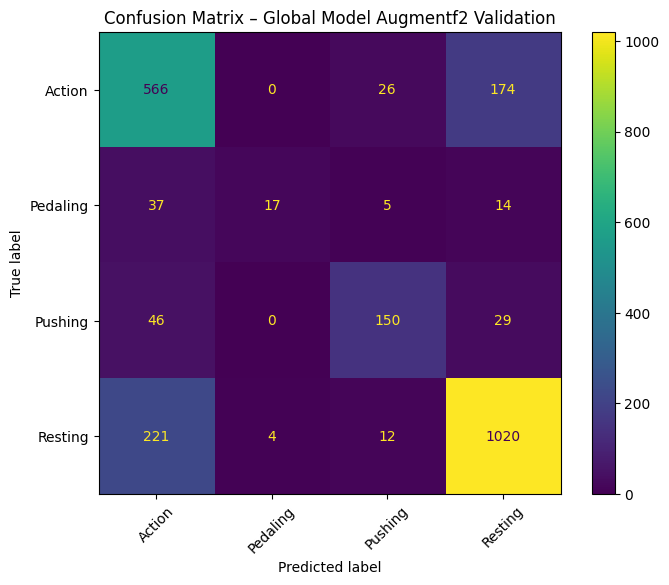

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.multiclass import unique_labels
import random
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# 💾 Speicherpfade anlegen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

#Data Augmentation

def augment_time_series_multiclass(X, y, augment_factor=2, jitter_std=0.01, scale_range=(0.9, 1.1),
                                   permute_segments=3, apply_mixup=False, seed=42):
    """
    Führt Data Augmentation für multiklassige Zeitreihen durch.

    Args:
        X (np.array): Zeitreihendaten (N, T, F)
        y (np.array): Labels (N,)
        augment_factor (int): Wie viele zusätzliche augmentierte Samples pro Original (z. B. 2x = verdreifacht)
        jitter_std (float): Standardabweichung für Jittering (z. B. 0.01)
        scale_range (tuple): Min/Max Faktor für Scaling (z. B. (0.9, 1.1))
        permute_segments (int): Anzahl Segmente für Shuffle (z. B. 3)
        apply_mixup (bool): Ob Mixup verwendet werden soll (optional)
        seed (int): Random-Seed für Reproduzierbarkeit

    Returns:
        X_aug, y_aug: augmentierte Daten
    """
    np.random.seed(seed)
    random.seed(seed)

    N, T, F = X.shape
    X_aug = []
    y_aug = []

    def jitter(x):
        return x + np.random.normal(loc=0., scale=jitter_std, size=x.shape)

    def scale(x):
        factor = np.random.uniform(*scale_range)
        return x * factor

    def permute(x):
        segs = np.array_split(x, permute_segments)
        np.random.shuffle(segs)
        return np.concatenate(segs, axis=0)

    def mixup(x1, x2, y1, y2):
        alpha = np.random.beta(0.4, 0.4)
        x_mix = alpha * x1 + (1 - alpha) * x2
        # Label bleibt einfach y1 oder y2 – einfacher Ansatz
        return x_mix, y1 if np.random.rand() < 0.5 else y2

    for i in range(N):
        for _ in range(augment_factor):
            x_aug = X[i]

            # Transformationen
            if np.random.rand() < 0.5:
                x_aug = jitter(x_aug)
            if np.random.rand() < 0.5:
                x_aug = scale(x_aug)
            if np.random.rand() < 0.3:
                x_aug = permute(x_aug)

            if apply_mixup and np.random.rand() < 0.3:
                idx2 = np.random.randint(0, N)
                x_aug, y_mix = mixup(x_aug, X[idx2], y[i], y[idx2])
                y_aug.append(y_mix)
            else:
                y_aug.append(y[i])

            X_aug.append(x_aug)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    # Zusammenführen
    X_combined = np.concatenate([X, X_aug])
    y_combined = np.concatenate([y, y_aug])

    return X_combined, y_combined




# 1️⃣ Sessions zusammenführen (dieser Teil muss mit deinen Daten ergänzt werden!)
# Beispiel:
X_all = np.concatenate(sessions_X)
y_all = np.concatenate(sessions_y)

# 2️⃣ Labels encoden
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)


# joblib.dump(le, "/content/drive/MyDrive/mtb_project/label_encoder.pkl") #speicherung der labels für Auswertung später


# 3️⃣ Train/Val-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.1, random_state=42, stratify=y_all_enc
)

# 4️⃣ Augmentieren – auf Original-Labels
y_train_original = le.inverse_transform(y_train)
X_aug, y_aug = augment_time_series_multiclass(X_train, y_train_original)
y_aug_enc = le.transform(y_aug)

# 🔀 Kombinieren
X_train_combined = np.concatenate([X_train, X_aug])
y_train_combined = np.concatenate([y_train, y_aug_enc])

# 5️⃣ Modell bauen
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6️⃣ Callback für Checkpoints
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "global_epoch_{epoch:02d}.keras"),
    save_best_only=True, save_weights_only=False, verbose=1
)

# 7️⃣ Training
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[checkpoint_cb]
)

# 8️⃣ Speichern des finalen Modells
model.save(os.path.join(final_model_dir, "global_final_augment_factor2.keras"))

# 9️⃣ Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\n✅ Validation Accuracy: {val_acc:.2f}")

# 🔮 Vorhersagen
y_pred_probs = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 📊 Report + Matrix
labels_present = unique_labels(y_val, y_pred_classes)
report_text = classification_report(
    y_val, y_pred_classes,
    labels=labels_present,
    target_names=[le.classes_[i] for i in labels_present]
)
print("\n📄 Classification Report:\n")
print(report_text)

# 💾 Speichern als Text
with open(os.path.join(report_dir, "global_model_augmentf2_classification_report{timestamp}.txt"), "w") as f:
    f.write(report_text)

# 📈 Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes, labels=labels_present)
disp = ConfusionMatrixDisplay(cm, display_labels=[le.classes_[i] for i in labels_present])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Global Model Augmentf2 Validation")

# 💾 Speichern als PNG
plt.savefig(os.path.join(report_dir, "global_model_confusion_matrix_augmentfactor2{timestamp}.png"))
plt.show()


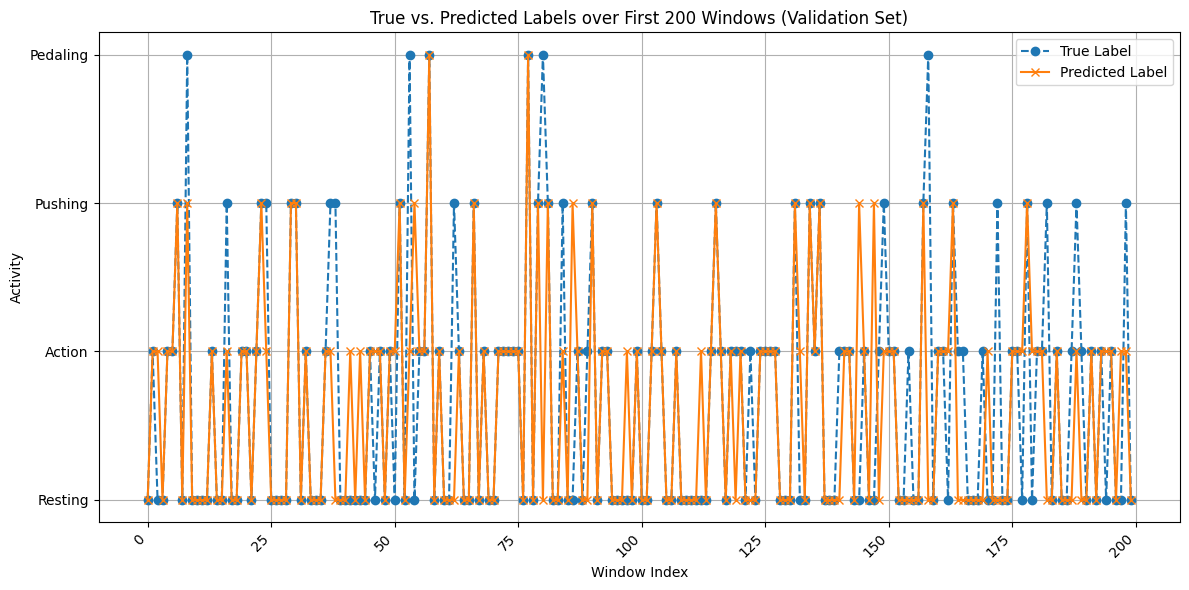

In [ ]:
# prompt: plot the labels against the prediction over time for the first 200 windows

plt.figure(figsize=(12, 6))
plt.plot(le.inverse_transform(y_val[:200]), label='True Label', marker='o', linestyle='--')
plt.plot(le.inverse_transform(y_pred_classes[:200]), label='Predicted Label', marker='x', linestyle='-')
plt.title('True vs. Predicted Labels over First 200 Windows (Validation Set)')
plt.xlabel('Window Index')
plt.ylabel('Activity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Code 2 - Model train with all augmentation factors

Hier kommt ein sauberes Trainings-Skript, das für alle gewünschten augment_factor-Werte deine Modelle trainiert und speichert

So läuft das:

    Für jeden augment_factor wird separat trainiert

    Modelle landen in /final_models_global/global_aug_factor_X.keras

    LabelEncoder wird einmal gespeichert für die spätere Analyse

    Du kannst danach dein Analyse-Notebook von oben starten und die Ergebnisse bequem vergleichen

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib

# Speicherorte anpassen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Deine augment_time_series_multiclass Funktion hier rein (oder importieren)

# 1. Daten laden (deine Sessions zusammenführen)
X_all = np.concatenate(sessions_X)
y_all = np.concatenate(sessions_y)

# 2. Labels encoden
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)

# LabelEncoder speichern
joblib.dump(le, os.path.join(final_model_dir, "label_encoder.pkl"))

# 3. Train/Val-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.1, random_state=42, stratify=y_all_enc
)

# 4. Augmentierungsfaktoren zum Testen
augment_factors = [0, 1, 2, 3]

for factor in augment_factors:
    print(f"\n🎯 Training mit augment_factor={factor} ...")

    if factor > 0:
        # Labels vor der Augmentation zurückkonvertieren
        y_train_orig = le.inverse_transform(y_train)
        X_aug, y_aug = augment_time_series_multiclass(
            X_train, y_train_orig,
            augment_factor=factor,
            jitter_std=0.01,
            scale_range=(0.9, 1.1),
            permute_segments=3,
            apply_mixup=True
        )
        y_aug_enc = le.transform(y_aug)

        # Kombinieren
        X_train_combined = np.concatenate([X_train, X_aug])
        y_train_combined = np.concatenate([y_train, y_aug_enc])
    else:
        X_train_combined = X_train
        y_train_combined = y_train

    # Modell bauen
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(100, activation='relu'),
        layers.Dense(len(le.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Checkpoint Callback
    checkpoint_cb = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, f"global_aug_factor_{factor}_epoch_{{epoch:02d}}.keras"),
        save_best_only=True, save_weights_only=False, verbose=1
    )

    # Trainieren
    history = model.fit(
        X_train_combined, y_train_combined,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[checkpoint_cb]
    )

    # Bestes Modell speichern (letztes oder bestes aus Checkpoints)
    model.save(os.path.join(final_model_dir, f"global_aug_factor_{factor}.keras"))

print("\n✅ Alle Modelle trainiert und gespeichert!")



🎯 Training mit augment_factor=0 ...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5110 - loss: 1.0639
Epoch 1: val_loss improved from inf to 0.96390, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_aug_factor_0_epoch_01.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5113 - loss: 1.0635 - val_accuracy: 0.5816 - val_loss: 0.9639
Epoch 2/50
 88/327 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5435 - loss: 0.9967

KeyboardInterrupt: 

#🧾 Zusammenfassung Modeltraining
##📊 1. Durchschnittliche Accuracy über alle Sessions:

In [ ]:
#📊 1. Durchschnittliche Accuracy über alle Sessions:

mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")


NameError: name 'all_accuracies' is not defined

##📁 2. CSV speichern (falls nicht schon vorhanden):

In [ ]:
#📁 2. CSV speichern (falls nicht schon vorhanden):

import pandas as pd

df_summary = pd.DataFrame(accuracy_summary)
df_summary['Session'] = [f"Session_{i+1}" for i in range(len(all_accuracies))]
df_summary.to_csv("/content/drive/MyDrive/mtb_project/session_accuracy_report.csv", index=False)
print("✅ Bericht gespeichert unter: session_accuracy_report.csv")


✅ Bericht gespeichert unter: session_accuracy_report.csv


In [ ]:
os.makedirs("/content/drive/MyDrive/mtb_project/reports", exist_ok=True)


# 🧾 Zusammenfassung nach dem Training:

Nach der Schleife kannst du am Ende folgendes hinzufügen, um einen Bericht zu erzeugen:

📊 Bonus: CSV speichern (optional)

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")




NameError: name 'all_accuracies' is not defined

#💾 II. Modell speichern & später wieder laden (z. B. nach Training)

##🔐 Speichern mit TensorFlow/**Keras**

In [ ]:
# Nach dem Training:
#speichert mit timestamp
#model.save("SenseCap_Eventdetection_Model.keras")  # speichert nur in colab kurzzeitig
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f"/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor2{timestamp}.keras")



##🔄 Laden

Das speichert das gesamte Modell inkl. Architektur, Gewichten und Optimizer-Zustand –exakt da weitermachen, wo man aufgehört hast.

In [ ]:


from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Eventdetection_Model1.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
all_accuracies = []

for i in range(len(test_sessions_X)):
    X_test = test_sessions_X[i]
    y_test = test_sessions_y[i]

    _, acc = model.evaluate(X_test, y_test, verbose=0)
    all_accuracies.append(acc)


NameError: name 'test_sessions_X' is not defined

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")





📈 Zusammenfassung:

✅ Durchschnittliche Test-Accuracy über alle Sessions: nan
📁 Bericht gespeichert als session_accuracy_report.csv
